# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations

asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['MANY', 'WRITE', 'BROCCOLI', 'VISIT', 'SUE', 'WILL', 'COAT', 'GO2', 'EAT', 'BUY1', 'FINISH', 'GIVE3', 'HOUSE', 'ARRIVE', 'GIVE1', 'TEACHER', 'STOLEN', 'SOMETHING-ONE', 'CAN', 'BOOK', 'MOTHER', 'MARY', 'LAST-WEEK', 'NEXT-WEEK', 'LIVE', 'HAVE', 'NAME', 'POTATO', 'MOVIE', 'KNOW', 'FRANK', 'CHOCOLATE', 'GO1', 'WHAT', 'FIND', 'CORN', 'CORN1', 'HOMEWORK', 'TOMORROW', 'WANT', 'BLUE', 'PAST', 'JOHN', 'FRED', 'GET', 'BLAME', 'THINK', 'SHOOT', 'SELL', 'JANA', 'IX', 'CHINA', 'GO', 'WHO', 'CHICKEN', 'OLD', 'MAN', 'BUT', 'TOY1', 'LOVE', 'FRIEND', 'TOY', 'SAY-1P', 'CAR', 'GIVE2', 'LEAVE', 'WONT', 'BUY', 'SELF', 'SHOULD', 'TELL', 'APPLE', 'POSS', 'THROW', 'READ', 'HIT', 'CANDY', 'SEARCH-FOR', 'LIKE', 'SAY', 'STUDENT', 'BROTHER', 'YESTERDAY', 'FUTURE', 'BILL', 'SEE', 'VIDEOTAPE', 'BOY', 'PEOPLE', 'ANN', 'NEW-YORK', 'BOX', 'HERE', 'PARTY', 'BREAK-DOWN', 'NEW', 'PREFER', 'NOT', 'PUTASIDE', 'WOMAN', 'VEGETABLE', 'GIVE', 'FISH', 'GROUP', 'BORROW', 'GIRL', 'IX-1P', 'ALL', 'CHICAGO', 'FUTUR

In [7]:
training.get_all_Xlengths()

{'ALL': (array([[-64,  36,  31, 180],
         [-64,  36,  31, 180],
         [-64,  36,  31, 180],
         [-64,  36,  31, 180],
         [-71,  39,  31, 180],
         [-71,  39,  31, 180],
         [-76,  43,  31, 180],
         [-76,  43,  31, 180],
         [-60,  39,  35, 181],
         [-60,  39,  34, 177],
         [-54,  26,  32, 177],
         [-47,  23,  27, 169],
         [-62,  35,  22, 181],
         [-81,  29,  19, 182],
         [-92,  27,  17, 181],
         [-97,  28,  17, 181],
         [-97,  28,  17, 181],
         [-86,  21,  17, 181],
         [-68,  22,  21, 184],
         [-49,  18,  24, 183],
         [-38,  15,  25, 181],
         [-31,   9,  25, 181],
         [-28,   8,  28, 180]]), [12, 11]),
 'ANN': (array([[ 11, 115, -10, 131],
         [ 10, 100, -10, 131],
         [  5,  87, -10, 131],
         [  2,  76, -10, 131],
         [  4,  68, -10, 131],
         [  0,  61, -10, 131],
         [ -1,  53, -10, 131],
         [ -4,  46, -10, 131],
         [ -

In [8]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [9]:
df_means = asl.df.groupby('speaker').mean()
df_means

left-x      left-y     right-x     right-y      nose-x  \
speaker                                                               
man-1    206.248203  218.679449  155.464350  150.371031  175.031756   
woman-1  164.661438  161.271242  151.017865  117.332462  162.655120   
woman-2  183.214509  176.527232  156.866295  119.835714  170.318973   

            nose-y    grnd-ry    grnd-rx     grnd-ly    grnd-lx  
speaker                                                          
man-1    61.642600  88.728430 -19.567406  157.036848  31.216447  
woman-1  57.245098  60.087364 -11.637255  104.026144   2.006318  
woman-2  58.022098  61.813616 -13.452679  118.505134  12.895536

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [10]:
df_means['left-x']

speaker
man-1      206.248203
woman-1    164.661438
woman-2    183.214509
Name: left-x, dtype: float64

In [11]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [12]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


left-x     left-y    right-x    right-y    nose-x    nose-y  \
speaker                                                                   
man-1    15.154425  36.328485  18.901917  54.902340  6.654573  5.520045   
woman-1  17.573442  26.594521  16.459943  34.667787  3.549392  3.538330   
woman-2  15.388711  28.825025  14.890288  39.649111  4.099760  3.416167   

           grnd-ry    grnd-rx    grnd-ly    grnd-lx  left-x-mean  
speaker                                                           
man-1    53.487999  20.269032  36.572749  15.080360          0.0  
woman-1  33.972660  16.764706  27.117393  17.328941          0.0  
woman-2  39.128572  16.191324  29.320655  15.050938          0.0

In [13]:
# Add remaining means and std values
asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['nose-x-mean']= asl.df['speaker'].map(df_means['nose-x'])
asl.df['nose-y-mean']= asl.df['speaker'].map(df_means['nose-y'])


asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['nose-y-std']= asl.df['speaker'].map(df_std['nose-y'])
asl.df['nose-x-std']= asl.df['speaker'].map(df_std['nose-x'])

In [14]:
asl.df.iloc[0, :]

left-x              149
left-y              181
right-x             170
right-y             175
nose-x              161
nose-y               62
speaker         woman-1
grnd-ry             113
grnd-rx               9
grnd-ly             119
grnd-lx             -12
left-x-mean     164.661
left-y-mean     161.271
right-y-mean    117.332
right-x-mean    151.018
nose-x-mean     162.655
nose-y-mean     57.2451
left-x-std      17.5734
left-y-std      26.5945
right-y-std     34.6678
right-x-std     16.4599
nose-y-std      3.53833
nose-x-std      3.54939
Name: (98, 0), dtype: object

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [15]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean'])/asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean'])/asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean'])/asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean'])/asl.df['left-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [16]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
asl.df['polar-rr'] = np.sqrt(np.square(asl.df['right-x'] - asl.df['nose-x']) 
                             + np.square(asl.df['right-y'] - asl.df['nose-y']))

asl.df['polar-lr'] = np.sqrt(np.square(asl.df['left-x'] - asl.df['nose-x']) 
                             + np.square(asl.df['left-y'] - asl.df['nose-y']))

asl.df['polar-rtheta'] = np.arctan2(asl.df['right-x'] - asl.df['nose-x'], 
                                    asl.df['right-y'] - asl.df['nose-y'])

asl.df['polar-ltheta'] = np.arctan2(asl.df['left-x'] - asl.df['nose-x'], 
                                    asl.df['left-y'] - asl.df['nose-y'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']


In [17]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-rx'] = (asl.df['right-x'] - asl.df['right-x'].shift()).fillna(0)

asl.df['delta-ry'] = (asl.df['right-y'] - asl.df['right-y'].shift()).fillna(0)

asl.df['delta-lx'] = (asl.df['left-x'] - asl.df['left-x'].shift()).fillna(0)

asl.df['delta-ly'] = (asl.df['left-y'] - asl.df['left-y'].shift()).fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [18]:
def euclidean(x, y, x1, y1):
    return np.sqrt(np.square(x - x1) + np.square(y - y1))

In [19]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# TODO define a list named 'features_custom' for building the training set

asl.df['custom-rn'] = euclidean(asl.df['right-x'], asl.df['right-y'], asl.df['nose-x'], asl.df['nose-y']) 
asl.df['custom-ln'] = euclidean(asl.df['left-x'], asl.df['left-y'], asl.df['nose-x'], asl.df['nose-y'])
asl.df['custom-rl'] = euclidean(asl.df['right-x'], asl.df['right-y'], asl.df['left-x'], asl.df['left-y'])

features_custom = ['custom-rn', 'custom-ln', 'custom-rl']

In [20]:
df_mean1 = asl.df.groupby('speaker').mean()
df_std1 = asl.df.groupby('speaker').std()

In [21]:
asl.df['custom-rn-mean']= asl.df['speaker'].map(df_mean1['custom-rn'])
asl.df['custom-ln-mean']= asl.df['speaker'].map(df_mean1['custom-ln'])
asl.df['custom-rl-mean']= asl.df['speaker'].map(df_mean1['custom-rl'])
asl.df['custom-rn-std']= asl.df['speaker'].map(df_std1['custom-rn'])
asl.df['custom-ln-std']= asl.df['speaker'].map(df_std1['custom-ln'])
asl.df['custom-rl-std']= asl.df['speaker'].map(df_std1['custom-rl'])

In [22]:
asl.df['custom-rn-norm'] = (asl.df['custom-rn'] - asl.df['custom-rn-mean'])/asl.df['custom-rn-std']
asl.df['custom-ln-norm'] = (asl.df['custom-ln'] - asl.df['custom-ln-mean'])/asl.df['custom-ln-std']
asl.df['custom-rl-norm'] = (asl.df['custom-rl'] - asl.df['custom-rl-mean'])/asl.df['custom-rl-std']

features_custom = ['custom-rn-norm', 'custom-ln-norm', 'custom-rl-norm']

In [23]:
asl.df.loc[:,features_custom]

custom-rn-norm  custom-ln-norm  custom-rl-norm
video frame                                                
98    0            1.573439        0.542499       -1.098073
      1            1.573439        0.542499       -1.098073
      2            1.573439        0.542499       -1.098073
      3            1.573439        0.542499       -1.098073
      4            1.573439        0.542499       -1.098073
      5            1.573439        0.542499       -1.098073
      6            1.573439        0.542499       -1.098073
      7            1.573439        0.542499       -1.098073
      8            1.573439        0.542499       -1.098073
      9            1.573439        0.542499       -1.098073
      10           1.573439        0.542499       -1.098073
      11           1.505914        0.542499       -1.107304
      12           1.241241        0.542499       -1.028980
      13           1.076593        0.542499       -0.938556
      14           0.715278        0.542499       -0.682170
      15           0.193704        0.542499       -0.266440
      16          -0.246847        0.542499        0.143041
      17          -0.445206        0.542499        0.464388
      18          -0.298568        0.709233        0.823021
      19          -0.141011        0.709233        1.117960
      20          -0.121524        0.709233        1.307372
      21          -0.115423        0.784032        1.307372
      22          -0.305575        0.784032        1.337438
      23          -0.603838        0.784032        1.344756
      24          -0.662348        0.784032        1.293158
      25          -0.763365        0.863186        1.293158
      26          -0.855620        0.863186        1.309222
      27          -0.993998        0.863186        1.389514
      28          -1.155705        0.863186        1.503804
      29          -1.155705        0.863186        1.503804
...                     ...             ...             ...
125   27          -0.694731       -1.925044       -0.454861
      28          -0.633876       -1.880904       -0.454861
      29          -0.688789       -1.990228       -0.530593
      30          -0.561051       -1.990228       -0.459195
      31          -0.504556       -1.901330       -0.250128
      32          -0.663804       -1.916424       -0.296707
      33          -0.782260       -1.916424       -0.268650
      34          -0.898270       -1.786878       -0.123137
      35          -0.764929       -1.688518       -0.083303
      36          -0.865724       -1.773232       -0.083303
      37          -0.811517       -2.058479       -0.494395
      38          -0.708191       -2.256885       -1.068401
      39          -0.563435       -2.018858       -1.274152
      40          -0.461124       -1.903040       -1.274152
      41          -0.467213       -1.899962       -1.274152
      42          -0.467213       -1.899962       -1.274152
      43          -0.440460       -1.856627       -1.274152
      44          -0.283477       -1.658634       -1.300650
      45          -0.283477       -1.182946       -1.036049
      46          -0.124980       -0.832166       -0.981268
      47          -0.097756       -0.396615       -0.716263
      48           0.028774        0.041042       -0.507472
      49           0.225166        0.248672       -0.507847
      50           0.389276        0.455885       -0.475209
      51           0.722763        0.630178       -0.539809
      52           1.020923        0.630178       -0.724393
      53           1.316288        0.630178       -0.882308
      54           1.586080        0.630178       -0.903384
      55           1.586080        0.630178       -0.903384
      56           1.586080        0.630178       -0.903384

[15746 rows x 3 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

My custom feature set has 3 features:

    a. Normalized distance between right hand and nose
    b. Normalized distance between left hand and nose
    c. Normalized distance between right hand and left

I first calculated the distances between these three points, then normalized them based on man-1, woman-1 and woman-2 so that the relative body size and length of arms are comparable.

My reason for doing this is from the observation that all actions are in relation to these three points. And as they move, their distances fluctuate. My guess is that these fluctions, as captured by the three features, will be discriminative enough to distinguish between words.



<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [24]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.009s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [25]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000, random_state=42).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
num_hidden_states = 7

model, logL = train_a_word(demoword, num_hidden_states, features_ground)
print("\nfeatures_norm:")
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))


features_norm:
Number of states trained in model for BOOK is 7
logL = -2040.8853580649352


In [26]:

demoword = 'BOOK'
num_hidden_states = 3

model, logL = train_a_word(demoword, num_hidden_states, features_norm)
print("\nfeatures_norm:")
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

model, logL = train_a_word(demoword, num_hidden_states, features_polar)
print("\nfeatures_polar:")
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

model, logL = train_a_word(demoword, num_hidden_states, features_delta)
print("\nfeatures_delta:")
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

model, logL = train_a_word(demoword, num_hidden_states, features_custom)
print("\nfeatures_custom:")
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))


features_norm:
Number of states trained in model for BOOK is 3
logL = -130.71089221940204

features_polar:
Number of states trained in model for BOOK is 3
logL = -901.0844114013482

features_delta:
Number of states trained in model for BOOK is 3
logL = -663.7695656348736

features_custom:
Number of states trained in model for BOOK is 3
logL = 80.46703268708875


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [27]:
model, logL = train_a_word(demoword, num_hidden_states, features_norm)
print("\nfeatures_norm:")
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))



features_norm:
Number of states trained in model for BOOK is 3
logL = -130.71089221940204


In [28]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ 1.16050793 -0.3361429  -0.5022096  -2.22073513]
variance =  [ 0.13396219  0.03829545  0.45021762  0.11123555]

hidden state #1
mean =  [ 0.55254803  0.1782496  -0.34612882 -1.39504558]
variance =  [ 0.06906066  0.08221395  0.07482992  0.11132208]

hidden state #2
mean =  [ 0.43609316 -0.22686509  0.39433383 -2.0344738 ]
variance =  [ 0.03713059  0.0184008   0.13829084  0.0787966 ]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [29]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 4, features_delta) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [ 0.  0.  0.  0.]
variance =  [ 0.00052632  0.00052632  0.00052632  0.00052632]

hidden state #1
mean =  [ 2.76994105 -0.69297837 -1.23056846 -9.38600161]
variance =  [ 8.64270298  7.44798691  5.10321527  8.54498396]

hidden state #2
mean =  [-0.64930241  3.33919218  0.32041023  0.64084519]
variance =  [ 34.12410128  12.09270716   0.44689876   1.78443456]

hidden state #3
mean =  [-0.88552109  3.00066765  1.96437471  1.61811063]
variance =  [  4.07484096  18.21181219  19.72609135  59.32818035]

logL = -118.30375532965529


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [30]:
%matplotlib inline

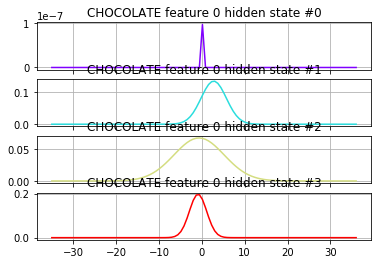

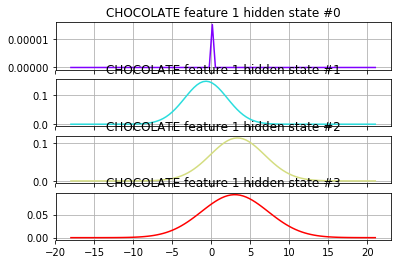

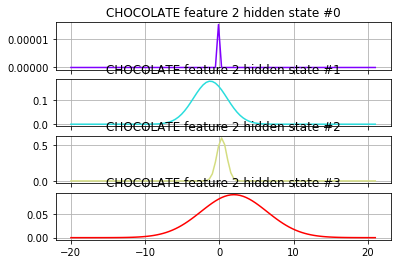

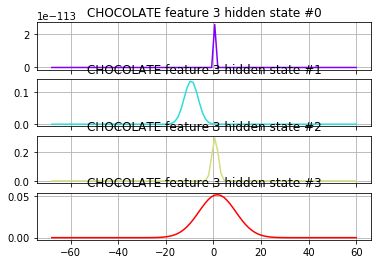

In [31]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [32]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [33]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [34]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit
import importlib

In [35]:
###########################################################
# TODO: Implement SelectorCV in my_model_selector.py
###########################################################
from my_model_selectors import SelectorCV

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.3517666879997705 seconds
Training complete for BOOK with 2 states with time 2.4531272379972506 seconds
Training complete for VEGETABLE with 12 states with time 1.0302361540016136 seconds
Training complete for FUTURE with 3 states with time 1.8686040370012051 seconds
Training complete for JOHN with 6 states with time 25.39730682800291 seconds


In [36]:
###########################################################
# TODO: Implement SelectorBIC in module my_model_selectors.py
###########################################################
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14, verbose=True).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

model created for FISH with 2 states
model created for FISH with 3 states
model created for FISH with 4 states
model created for FISH with 5 states
model created for FISH with 6 states
model created for FISH with 7 states
model created for FISH with 8 states
model created for FISH with 9 states
model created for FISH with 10 states
model created for FISH with 11 states
model created for FISH with 12 states
model created for FISH with 13 states
model created for FISH with 14 states
model created for FISH with 15 states
Training complete for FISH with 5 states with time 0.30985748799866997 seconds
model created for BOOK with 2 states
model created for BOOK with 3 states
model created for BOOK with 4 states
model created for BOOK with 5 states
model created for BOOK with 6 states
model created for BOOK with 7 states
model created for BOOK with 8 states
model created for BOOK with 9 states
model created for BOOK with 10 states
model created for BOOK with 11 states
model created for BOOK wi

In [37]:
###########################################################
# TODO: Implement SelectorDIC in module my_model_selectors.py
###########################################################
from my_model_selectors import SelectorDIC

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()

In [38]:
import my_model_selectors
from importlib import reload


reload(my_model_selectors)


for word in words_to_train:
    start = timeit.default_timer()
    model = my_model_selectors.SelectorDIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, 
                        random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 105.58907975799957 seconds
Training complete for BOOK with 15 states with time 0.24746387099730782 seconds
Training complete for VEGETABLE with 5 states with time 0.028885952997370623 seconds
Training complete for FUTURE with 15 states with time 0.2614832530016429 seconds
Training complete for JOHN with 15 states with time 2.274275535994093 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

We build three model selectors:

**BIC:**

BIC rewards higher log likelihood, but penalizes increase in complexity (num of parameters). It it fast to calculate since it focuses on the model and the word at hand (doesn't look into other words like DIC does). From the readings that I got in section 3, BIC was able to produce better models than DIC or CV.


**DIC:**

Takes longer time to calculate since the log likelihood of all combinations of words and number of components needs to be calculated. Scalling it up can be a challenge. Ofcourse, the results can be cached for any subsequent scoring. 

However, on the positive side, it takes into account likelihood of a word compared to other competing words. Which is to say DIC score will be low if there is ambiguity and high if there is clarity in the prediction.


**Cross Validation based model selector:**

Simple approach. Helps models to be more generalized. But requires sufficient training data so as to be able to create enough folds for evaluation.



<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [39]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 29.836s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [40]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%reload_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_norm, SelectorBIC)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [41]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [42]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [43]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5898876404494382
Total correct: 73 out of 178


In [44]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

# TODO Choose a feature set and model selector
features = features_norm # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6123595505617978
Total correct: 69 out of 178


In [45]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178


In [46]:
# Here I run all the combinations together to get the best one
# ==========================================================================================

features = [features_custom, features_norm, features_delta, features_ground, features_polar]
model_selectors = [SelectorBIC, SelectorDIC, SelectorCV]


for f in features:
    for m in model_selectors:
        print ("\nModel: {0}, Features: {1}".format(m, f))
        print ("========================================================================")
        models = train_all_words(f, m)
        test_set = asl.build_test(f)
        probabilities, guesses = recognize(models, test_set)
        show_errors(guesses, test_set)


Model: <class 'my_model_selectors.SelectorBIC'>, Features: ['custom-rn-norm', 'custom-ln-norm', 'custom-rl-norm']

**** WER = 0.5617977528089888
Total correct: 78 out of 178

Model: <class 'my_model_selectors.SelectorDIC'>, Features: ['custom-rn-norm', 'custom-ln-norm', 'custom-rl-norm']

**** WER = 0.601123595505618
Total correct: 71 out of 178

Model: <class 'my_model_selectors.SelectorCV'>, Features: ['custom-rn-norm', 'custom-ln-norm', 'custom-rl-norm']

**** WER = 0.5898876404494382
Total correct: 73 out of 178

Model: <class 'my_model_selectors.SelectorBIC'>, Features: ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

**** WER = 0.6123595505617978
Total correct: 69 out of 178

Model: <class 'my_model_selectors.SelectorDIC'>, Features: ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

**** WER = 0.6123595505617978
Total correct: 69 out of 178

Model: <class 'my_model_selectors.SelectorCV'>, Features: ['norm-rx', 'norm-ry', 'norm-lx', 'norm-ly']

**** WER = 0.6179775280898876
Total correc

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

The results I got are:

| Features       | BIC       | DIC      | CV      |
|----------------|-----------|----------|---------|
| custom         | 78/0.56   | 71/0.60  | 73/0.58 |
| norm           | 69/0.61   | 69/0.61  | 68/0.61 |
| delta          | 68/0.61   | 67/0.62  | 67/0.62 |
| ground         | 80/0.55   | 79/0.55  | 72/0.59 |
| polar          | 81/0.54   | 80/0.55  | 75/0.57 |


**Summary**

* Polar features performed the best, suggesting that the angles between the nose and hands are more representative of the hand gestures. It was 
* My custom feature performed better than norm and delta. It was also along the theme that fluctuations between the nose and two hands are representative of the hand gesture.
* It was surprising to see ground features performing next to polar.
* The BIC criteria gave is the best models, followed by DIC and CV. The reason for CV taking last place can be attributed to the fact that we had to choose 2 folds for CV due to insufficient datapoints. 
* Improvind WER: We can take advantage of patterns and usage of words in daily practice. A good analogy is the predictive text typing ability of our mobile phone keyboards. If you type "I will be", the predictive typing will give you suggestions like "late", "on time" etc. This is possible by having the agent learn the most probable sequence of usages in our daily life. Hence if such capability is combined along with HMM, I believe we will get better WER scores.


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [47]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 28.062s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [48]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

ALL  ANN         APPLE      ARRIVE        BILL       BLAME  \
0  -2514.595978 -inf  -2873.999359 -153.676884 -364.734073 -167.297801   
1  -7461.125249 -inf  -9899.007748 -104.947103 -439.111696 -124.539125   
2 -10608.535899 -inf -16163.432731 -258.599854 -696.141464 -270.136282   
3   -388.154469 -inf  -1814.923873 -288.041914 -365.059304 -257.134452   
4  -1450.047309 -inf  -3113.233817  -54.336629 -211.129742  -51.468688   

          BLUE        BOOK  BORROW         BOX     ...        VIDEOTAPE  \
0 -1381.845955 -860.450665    -inf -267.066499     ...      -410.801347   
1 -1062.632459  -72.686934    -inf -327.426386     ...       -90.504608   
2 -2492.608920 -508.055460    -inf -611.670139     ...      -325.595500   
3  -198.966164 -989.572674    -inf -278.975579     ...     -1064.595105   
4  -152.609410 -105.563380    -inf  -60.452932     ...      -150.962347   

        VISIT           WANT        WHAT         WHO          WILL  \
0 -125.045261  -35258.872750 -247.161516 -106.723360  -1202.845686   
1 -163.969164   -4124.727596 -220.616727 -299.384048  -4683.311313   
2 -326.028345   -6985.244118 -467.884312 -465.859304  -7178.194218   
3 -155.012822 -361409.104490 -329.523282 -333.071316 -11797.466033   
4  -62.327829  -10311.538522  -45.776386 -198.079779  -5438.745491   

         WOMAN        WONT  WRITE   YESTERDAY  
0  -657.289382 -326.867230   -inf -121.588190  
1  -415.254112 -328.834602   -inf -166.338571  
2 -1412.968856 -643.365494   -inf -345.202501  
3  -267.456250 -117.215175   -inf -414.595751  
4  -144.034438 -336.039267   -inf -155.996580  

[5 rows x 112 columns]